# Exploratory Data Analysis

This notebook is made for exploring the data and analyzing it.

## Imports

Imports that we need to take care of.

In [1]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from pandas import CategoricalDtype
from sklearn.model_selection import train_test_split


# Loading the data

Let's load the data into memory.

In [2]:
dfs = {}
datasets = ["data/2018/84468NED_UntypedDataSet_17032023_184722.csv", "data/2017/83901NED_UntypedDataSet_17032023_184829.csv", "data/2016/83903NED_UntypedDataSet_17032023_184919.csv"]


for dataset in datasets:
    findings = re.findall(r"(201\d)", dataset)
    year = findings[0]
    df = pd.read_csv(filepath_or_buffer=dataset, delimiter=";")
    relative_columns = df.columns.to_list()[-5:] #there are five relative columns, skip these for now
    print(relative_columns)
    df = df.drop(columns=relative_columns)
    dfs[year] = df


# Reading in the features for each municipality possibly related to the total crime number.
features_crime = pd.read_csv("data/FeaturesMisdaad.csv", delimiter=";")


['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']
['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']
['TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27', 'TotaalDiefstalUitWoningSchuurED_28', 'VernielingMisdrijfTegenOpenbareOrde_29', 'GeweldsEnSeksueleMisdrijven_30']


# Data Cleaning

Let's check if we could join them easily by comparing if they have the same headers.

In [3]:
for comb in combinations(dfs.keys(), r=2):
    year_0 = comb[0]
    year_1 = comb[1]
    if ((dfs[year_0].columns == dfs[year_1].columns).all() == False):
        print('Problem with combination', comb, ", not all columns match.")

Let's inspect if there is a data-related column. If there is, we can just join the table, else we need to make one to seperate the data of 2016, 2017, 2018 by.

In [4]:
dfs["2018"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16771 entries, 0 to 16770
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      16771 non-null  int64 
 1   WijkenEnBuurten                         16771 non-null  object
 2   Gemeentenaam_1                          16771 non-null  object
 3   SoortRegio_2                            16771 non-null  object
 4   Codering_3                              16771 non-null  object
 5   Indelingswijziging_4                    16771 non-null  object
 6   AantalInwoners_5                        16771 non-null  int64 
 7   TotaalVermogenVernielingEnGeweld_6      16771 non-null  object
 8   TotaalVermogensmisdrijven_7             16771 non-null  object
 9   TotaalDiefstal_8                        16771 non-null  object
 10  Fietsendiefstal_9                       16771 non-null  object
 11  Di

--> does not seem like it, so let's make a year column.

In [5]:
dfs["2018"].columns

Index(['ID', 'WijkenEnBuurten', 'Gemeentenaam_1', 'SoortRegio_2', 'Codering_3',
       'Indelingswijziging_4', 'AantalInwoners_5',
       'TotaalVermogenVernielingEnGeweld_6', 'TotaalVermogensmisdrijven_7',
       'TotaalDiefstal_8', 'Fietsendiefstal_9',
       'DiefstalOverigeVervoermiddelen_10',
       'DiefstalUitVanafVervoermiddelen_11',
       'ZakkenrollerijStraatroofEnBeroving_12',
       'TotaalDiefstalUitWoningSchuurED_13',
       'DiefstalUitNietResidentieleGebouwen_14', 'OverigeDiefstalInbraak_15',
       'OverigeVermogensmisdrijven_16', 'TotaalVernielingTegenOpenbareOrde_17',
       'TotaalVernieling_18', 'VernielingAanAuto_19', 'OverigeVernieling_20',
       'OverigeVernielingTegenOpenbareOrde_21',
       'TotaalGeweldsEnSeksueleMisdrijven_22', 'Mishandeling_23',
       'BedreigingEnStalking_24', 'OverigeGeweldsEnSeksueleMisdrijven_25'],
      dtype='object')

In [6]:
columns = dfs["2018"].columns.to_list()
cleaned_columns = []
for col in columns:
    cleaned_col = re.sub(r"(_\d+)", repl="", string=col)
    #r"(_+\d)" --> regular expression that looks for an underscore with after that at least one digit.
    cleaned_columns.append(cleaned_col)

#Go over every dataframe and change the column names
column_renamer = {columns[i]: cleaned_columns[i] for i in range(len(cleaned_columns))}
for key in dfs.keys():
    dfs[key] = dfs[key].rename(columns=column_renamer)

In [7]:
for key in dfs.keys():
    df = dfs[key]
    df["year"] = [year for _ in range(len(df))]

Let's create a big dataframe which holds all the data together

In [8]:
for key in dfs.keys():
    df = dfs[key]
    df = df.reset_index()
    df["ID"] = [str(id)+"_"+key for id in df["ID"].to_list()]
    dfs[key] = df

df_all = pd.DataFrame(columns=dfs["2018"].columns)

for key in dfs.keys():
    df_all = pd.concat([df_all, dfs[key]])
    dfs[key] = dfs[key].drop(columns="ID")

df_all = df_all.drop(columns="index")

In [9]:
df_all

,ID,WijkenEnBuurten,Gemeentenaam,SoortRegio,Codering,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,...,TotaalVernielingTegenOpenbareOrde,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde,TotaalGeweldsEnSeksueleMisdrijven,Mishandeling,BedreigingEnStalking,OverigeGeweldsEnSeksueleMisdrijven,year
0,0_2018,GM1680,Aa en Hunze,Gemeente,GM1680,.,25390,423,284,199,...,73,59,14,45,14,66,26,23,17,2016
1,1_2018,WK168000,Aa en Hunze,Wijk,WK168000,1,3560,38,22,16,...,9,8,1,7,1,7,3,3,1,2016
2,2_2018,BU16800000,Aa en Hunze,Buurt,BU16800000,1,3415,37,21,15,...,9,8,1,7,1,7,3,3,1,2016
3,3_2018,BU16800009,Aa en Hunze,Buurt,BU16800009,1,145,1,1,1,...,0,0,0,0,0,0,0,0,0,2016
4,4_2018,WK168001,Aa en Hunze,Wijk,WK168001,1,1430,19,16,12,...,1,1,0,1,0,2,1,0,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,16188_2016,BU01935150,Zwolle,Buurt,BU01935150,1,3199,33,20,13,...,9,9,2,7,0,4,0,4,0,2016
16189,16189_2016,BU01935160,Zwolle,Buurt,BU01935160,1,72,3,3,2,...,0,0,0,0,0,0,0,0,0,2016
16190,16190_2016,WK019352,Zwolle,Wijk,WK019352,1,867,17,9,6,...,6,6,1,5,0,2,0,0,2,2016
16191,16191_2016,BU01935200,Zwolle,Buurt,BU01935200,1,386,8,2,2,...,6,6,1,5,0,0,0,0,0,2016


Now, let's save it and try to load it (checking if it works).

In [10]:
df_all.to_csv(path_or_buf="data/all_data.csv", sep=";", index=False)

In [11]:
df_all = pd.read_csv(filepath_or_buffer="data/all_data.csv", delimiter=";")

Next, we realized that some of the '0' values were instead written as a '.', thus we decided to fix these 0's. Furthermore, some of the numerical data was represented as a string containing a space, thus the below functions fix these.

In [12]:
def fix_zeros(dataframes: dict[str, pd.DataFrame], key: str) -> dict[str, pd.DataFrame]:
    for dataframe in dataframes.values():
        dataframe[key] = dataframe[key].replace(r'(\s+)', "", regex=True) #replace all spaces with nothing
        dataframe[key] = dataframe[key].replace(r'(\.)', "0", regex=True) #replace the dots with 0
        dataframe[key] = dataframe[key].astype(int)

    return dfs

In [13]:
#CBS used . instead of 0s and strings instead of integers when loading data
#--> fixing it here
to_fix = ["TotaalVermogenVernielingEnGeweld", "TotaalVermogensmisdrijven", "TotaalDiefstal", "TotaalDiefstalUitWoningSchuurED", "TotaalVernielingTegenOpenbareOrde", "TotaalVernieling", "TotaalGeweldsEnSeksueleMisdrijven"]
for fixable in to_fix:
    dfs = fix_zeros(dataframes = dfs, key = fixable)

Below, we create a new dataframe from the original to only include each municipality and not also all neighbourhoods within this municipality.

In [14]:
dfs_Gemeente_All = df_all[df_all['SoortRegio'] == "Gemeente"]
Counter(df_all["Gemeentenaam"])
df_all["Gemeentenaam"] = df_all["Gemeentenaam"].replace(r'(\s+\s)', "", regex=True) #replace all spaces with another space behind it

In [15]:
Counter(dfs_Gemeente_All['Codering'])

l = dfs_Gemeente_All['Codering'].to_list()
l = [period[:6] for period in l]
dfs_Gemeente_All["Codering"] = l

Counter(dfs_Gemeente_All['Codering'])

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\537008061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_Gemeente_All["Codering"] = l


Counter({'GM1680': 3,
         'GM0738': 3,
         'GM0358': 3,
         'GM0197': 3,
         'GM0059': 3,
         'GM0482': 3,
         'GM0613': 3,
         'GM0361': 3,
         'GM0141': 3,
         'GM0034': 3,
         'GM0484': 3,
         'GM1723': 3,
         'GM0060': 3,
         'GM0307': 3,
         'GM0362': 3,
         'GM0363': 3,
         'GM0200': 3,
         'GM0003': 3,
         'GM0202': 3,
         'GM0106': 3,
         'GM0743': 3,
         'GM0744': 3,
         'GM0308': 3,
         'GM0489': 3,
         'GM0203': 3,
         'GM0005': 3,
         'GM0888': 3,
         'GM0370': 3,
         'GM0889': 3,
         'GM1945': 3,
         'GM1724': 3,
         'GM0893': 3,
         'GM0373': 3,
         'GM0748': 3,
         'GM1859': 3,
         'GM1721': 3,
         'GM0753': 3,
         'GM0209': 3,
         'GM0375': 3,
         'GM0310': 3,
         'GM0585': 3,
         'GM1728': 3,
         'GM0376': 3,
         'GM0377': 3,
         'GM1901': 3,
         '

Next, we convert the period column to a year column for the features data. 

In [16]:
periods = features_crime["Perioden"].to_list()
periods = [period[:4] for period in periods]
features_crime = features_crime.drop(columns="Perioden")
features_crime["Year"] = periods

features_crime.replace('', np.nan, inplace=True)
features_crime.dropna(inplace=True)
features_crime

,ID,RegioS,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypeEenpersoonshuishouden_133,TypeEenoudergezin_134,TypePaarZonderKind_135,TypePaarMetKindEren_136,BronInkomenAlsWerknemer_137,BronInkomenAlsZelfstandige_138,Werkloosheid_155,Year
0,1618,GM1680,12603.0,12683.0,1584.0,92.0,70.7,27.7,1.6,5.6,10.9,25.0,24.6,33.8,34.1,33.1,42.2,510.0,2017
1,1619,GM1680,12666.0,12724.0,1644.0,92.0,73.1,25.4,1.5,6.0,11.0,25.7,25.0,33.9,34.0,33.2,44.0,410.0,2018
2,1620,GM1680,12659.0,12727.0,1707.0,92.0,74.1,25.7,0.2,6.1,11.1,26.2,26.3,35.0,36.6,34.5,47.7,310.0,2019
3,1646,GM0738,6615.0,6452.0,759.0,259.0,71.6,28.3,0.2,3.4,4.9,24.2,26.0,32.9,33.7,31.2,41.9,160.0,2017
4,1647,GM0738,6684.0,6469.0,789.0,261.0,72.4,26.9,0.6,3.6,5.0,25.3,26.4,33.1,34.0,31.8,43.1,120.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,21891,GM0642,21643.0,22943.0,9831.0,2196.0,55.4,44.0,0.6,19.2,19.9,24.7,22.8,33.3,33.2,31.5,47.3,620.0,2018
2174,21892,GM0642,21656.0,22983.0,10111.0,2199.0,56.4,43.4,0.1,19.6,19.9,26.3,24.4,35.3,37.2,32.9,51.5,480.0,2019
2175,21918,GM0193,61727.0,63821.0,20559.0,1128.0,52.5,47.0,0.5,101.9,55.0,23.7,22.4,34.0,32.4,30.6,42.3,2400.0,2017
2176,21919,GM0193,62030.0,64086.0,21093.0,1135.0,52.3,47.2,0.5,103.0,55.8,24.1,23.2,33.5,33.2,30.9,43.8,2090.0,2018


# Visualizations

## Let's do so EDA when considering all datasets.

Firstly we wanted to have a look at the spread of our the crimes over the three given years. There is a slight, but not extreme, decrease over the three relevant years.

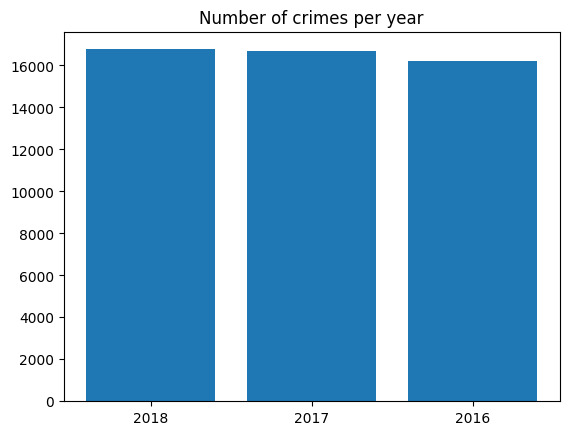

In [17]:
number_of_crimes = [len(dfs[x]) for x in dfs.keys()]
years = list(dfs.keys())

plt.bar(x=years, height=number_of_crimes)
plt.title("Number of crimes per year")
plt.show()


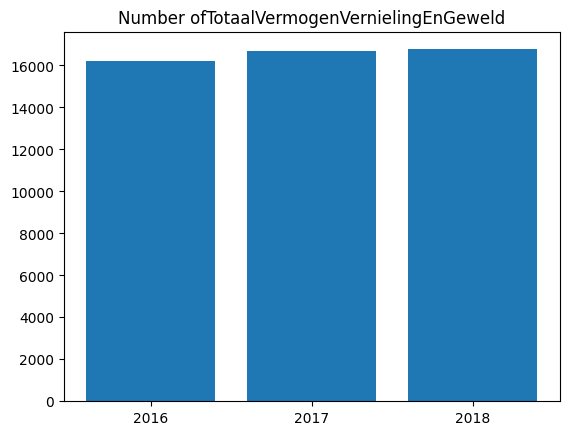

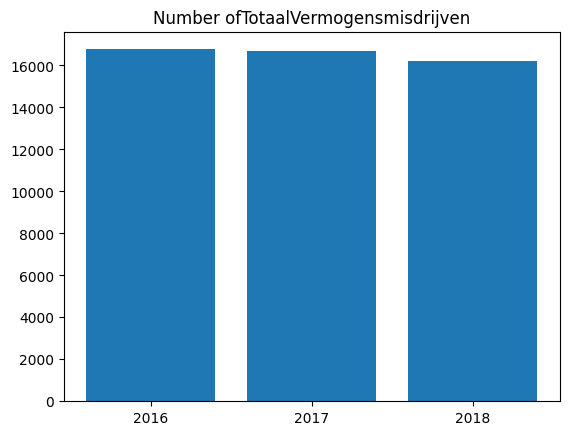

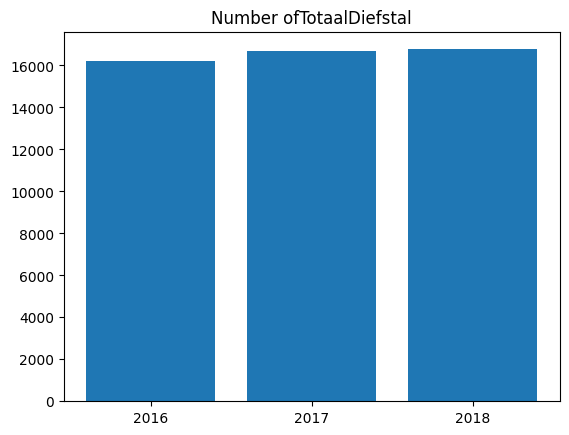

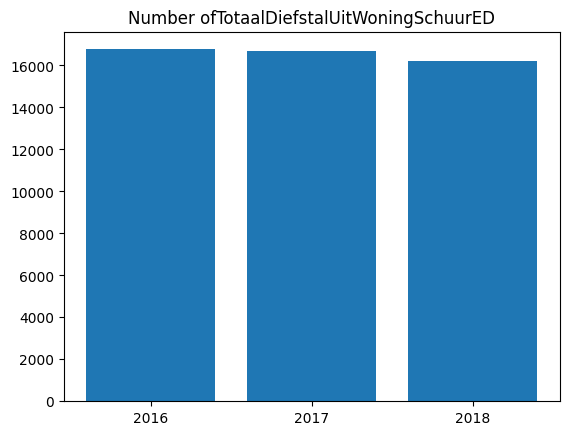

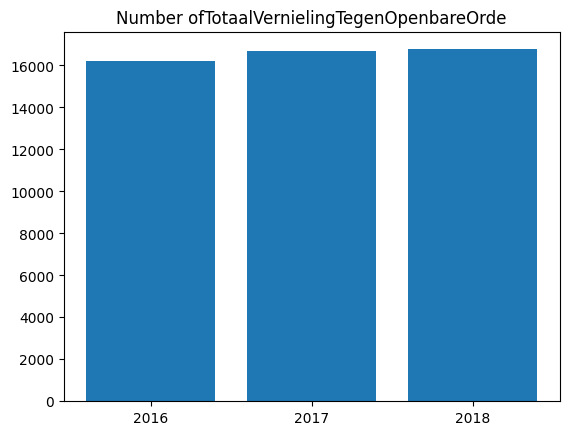

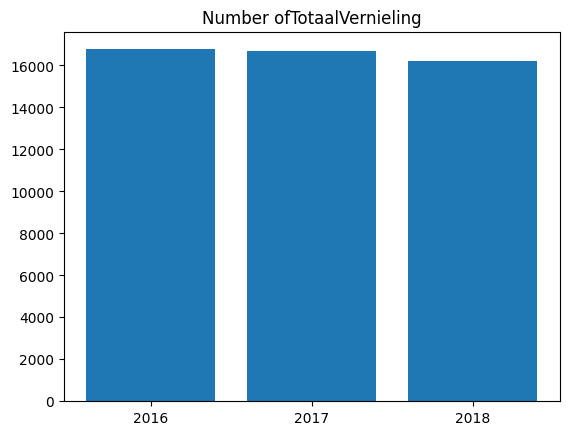

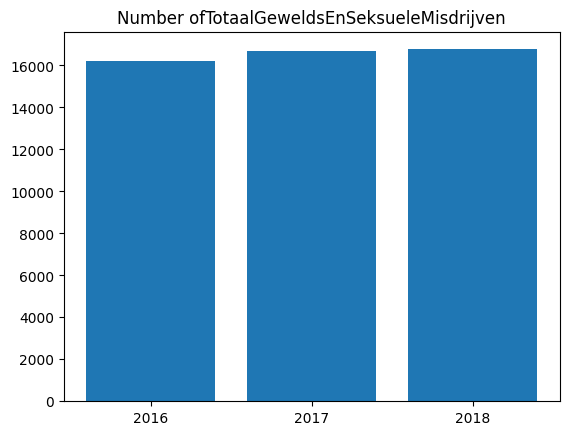

In [18]:
for fixed in to_fix:
    height = [sum(dfs[x][fixed]) for x in dfs.keys()]
    years = list(dfs.keys())

    number_of_crimes.reverse()
    years.reverse()

    plt.bar(x=years, height=number_of_crimes)
    plt.title(str("Number of" + fixed))
    plt.show()

## Let's do so EDA when considering each dataset separately.

In [19]:
#Counter(df_all['province'])

In [20]:
#df_all[df_all['province'].isna()]

In [21]:
#gemeentetest = pd.read_csv('data/Gemeenten alfabetisch 2018.csv', delimiter=";")
#gemeentetest = gemeentetest[['Gemeentenaam','Provincienaam']]

#testtest = pd.merge(df_all, gemeentetest[['Gemeentenaam','Provincienaam']], on='Gemeentenaam', how='inner')
#testtest

In [22]:
#gemeentetest = pd.read_csv('data/Gemeenten alfabetisch 2018.csv', delimiter=";")
#gemeentetest

#testtest = pd.merge(df_all,gemeentetest[['Gemeentenaam','Provincienaam']],on='Gemeentenaam', how='left')
#testtest
#gemeentetest['Provincienaam']


In [23]:
Counter(features_crime['RegioS'])

Counter({'GM1680': 3,
         'GM0738': 2,
         'GM0358': 3,
         'GM0197': 3,
         'GM0059': 3,
         'GM0482': 3,
         'GM0613': 3,
         'GM0361': 3,
         'GM0141': 3,
         'GM0034': 3,
         'GM0484': 3,
         'GM1723': 3,
         'GM1959': 1,
         'GM0060': 3,
         'GM0307': 3,
         'GM0362': 3,
         'GM0363': 3,
         'GM0200': 3,
         'GM0003': 3,
         'GM0202': 3,
         'GM0106': 3,
         'GM0743': 3,
         'GM0744': 3,
         'GM0308': 3,
         'GM0489': 3,
         'GM0203': 3,
         'GM0005': 2,
         'GM0888': 3,
         'GM1954': 1,
         'GM0370': 3,
         'GM0889': 3,
         'GM0007': 1,
         'GM1945': 3,
         'GM1724': 3,
         'GM0893': 3,
         'GM0373': 3,
         'GM0748': 3,
         'GM1859': 3,
         'GM1721': 3,
         'GM0753': 3,
         'GM0209': 3,
         'GM0375': 3,
         'GM0063': 1,
         'GM0310': 3,
         'GM0585': 2,
         '

In [24]:
# Verschil tussen alle gemeentes die we hadden en degene waar we features voor hadden.

A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

s = A.difference(B)
print(s)
print(len(s))

print(dfs_Gemeente_All.shape)
dfs_Gemeente_All = dfs_Gemeente_All[~dfs_Gemeente_All['Codering'].isin(list(s))]
print(dfs_Gemeente_All.shape)

A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

s = A.difference(B)
print(s)
print(len(s))

{'GM0860', 'GM0844', 'GM0846'}
3
(1158, 28)
(1155, 28)
set()
0


In [25]:
A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

s = B.difference(A)
print(s)
print(len(s))

print(features_crime.shape)
features_crime = features_crime[~features_crime['RegioS'].isin(list(s))]
print(features_crime.shape)

A = set(dfs_Gemeente_All['Codering'])
B = set(features_crime['RegioS'])

s = B.difference(A)
print(s)
print(len(s))

{'GM1954', 'GM1960', 'GM1970', 'GM1966', 'GM1969', 'GM1959', 'GM1963', 'GM1978', 'GM1961'}
9
(1123, 19)
(1114, 19)
set()
0


In [26]:
features_crime_average = features_crime.groupby('RegioS').mean()
display(features_crime_average)

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\2959682727.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  features_crime_average = features_crime.groupby('RegioS').mean()


,ID,Mannen_2,Vrouwen_3,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155
RegioS,,,,,,,,,,,,,
GM0003,2515.0,5757.666667,6073.333333,1661.333333,497.333333,48.733333,51.133333,0.166667,3.766667,5.533333,28.900000,29.033333,196.666667
GM0005,2906.5,5238.000000,5239.000000,790.000000,235.000000,68.450000,31.200000,0.400000,3.200000,4.350000,31.150000,30.150000,175.000000
GM0007,3130.0,4534.000000,4385.000000,973.000000,82.000000,70.600000,28.400000,1.000000,1.700000,4.000000,29.000000,29.600000,150.000000
GM0009,4054.5,3611.500000,3678.500000,515.500000,161.000000,76.600000,23.300000,0.100000,1.150000,2.950000,32.300000,30.900000,105.000000
GM0010,5203.0,12481.000000,12367.000000,4439.333333,187.000000,61.600000,37.933333,0.466667,10.566667,11.466667,29.500000,30.066667,413.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1949,19679.5,23404.500000,22665.500000,3980.500000,161.500000,67.450000,32.100000,0.400000,13.450000,20.000000,30.000000,29.800000,665.000000
GM1950,20407.5,12486.500000,12455.000000,2594.000000,90.500000,66.800000,29.700000,3.400000,7.500000,11.100000,29.200000,30.300000,340.000000
GM1952,12903.5,30561.500000,30364.500000,8712.500000,217.500000,61.900000,37.500000,0.600000,19.250000,27.300000,30.150000,30.000000,970.000000


In [27]:
def fix_zeros_Wouter(dataframe: pd.DataFrame, low: int, high: int) -> pd.DataFrame:
    for i in range(low, high):
        dataframe.iloc[:,i] =  dataframe.iloc[:,i].replace(r'(\s+)', "", regex=True)
        dataframe.iloc[:,i] =  dataframe.iloc[:,i].replace(r'(\.)', "0", regex=True)
        dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)

    return dataframe

In [28]:
dfs_Gemeente_All = fix_zeros_Wouter(dfs_Gemeente_All, low=5, high=24)


C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\2054924098.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)


In [29]:
dfs_Gemeente_All_average = dfs_Gemeente_All.groupby('Codering').mean()
display(dfs_Gemeente_All_average)

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\67170250.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_Gemeente_All_average = dfs_Gemeente_All.groupby('Codering').mean()


,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,Fietsendiefstal,DiefstalOverigeVervoermiddelen,DiefstalUitVanafVervoermiddelen,ZakkenrollerijStraatroofEnBeroving,TotaalDiefstalUitWoningSchuurED,DiefstalUitNietResidentieleGebouwen,OverigeDiefstalInbraak,OverigeVermogensmisdrijven,TotaalVernielingTegenOpenbareOrde,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde,TotaalGeweldsEnSeksueleMisdrijven,year
Codering,,,,,,,,,,,,,,,,,,,,
GM0003,0.0,11924.333333,352.666667,218.000000,171.000000,33.333333,8.666667,11.000000,3.000000,28.333333,56.000000,30.666667,47.000000,59.666667,47.333333,21.000000,26.333333,12.333333,75.000000,2016.0
GM0005,0.0,10462.333333,149.666667,97.666667,62.000000,8.333333,2.666667,4.333333,0.666667,19.666667,7.000000,19.333333,35.666667,33.000000,27.333333,10.000000,17.333333,5.666667,19.000000,2016.0
GM0007,0.0,8945.000000,178.500000,108.000000,76.000000,4.500000,3.000000,5.000000,0.000000,21.000000,16.500000,26.000000,32.000000,37.500000,31.500000,8.000000,23.500000,6.000000,33.000000,2016.0
GM0009,0.0,7310.666667,106.333333,68.333333,42.666667,9.666667,1.000000,3.000000,0.333333,8.666667,14.000000,6.000000,25.666667,24.333333,21.666667,6.000000,15.666667,2.666667,13.666667,2016.0
GM0010,0.0,24965.666667,858.666667,526.000000,427.333333,63.000000,11.333333,43.333333,14.333333,76.000000,134.333333,85.000000,98.666667,162.000000,129.333333,48.666667,80.666667,32.666667,170.666667,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1949,0.0,46112.000000,830.000000,499.000000,370.000000,64.000000,20.000000,48.000000,2.000000,89.000000,56.000000,91.000000,129.000000,187.000000,155.000000,76.000000,79.000000,32.000000,144.000000,2016.0
GM1950,0.0,24684.000000,915.000000,623.000000,542.000000,32.000000,6.000000,34.000000,9.000000,78.000000,285.000000,98.000000,81.000000,133.000000,94.000000,38.000000,56.000000,39.000000,159.000000,2016.0
GM1952,0.0,60951.000000,1433.000000,836.000000,585.000000,109.000000,36.000000,32.000000,6.000000,132.000000,138.000000,132.000000,251.000000,317.000000,251.000000,83.000000,168.000000,66.000000,280.000000,2016.0


In [30]:
features_crime_average.rename(columns={'RegioS':'Codering'}, inplace=True)
dfs_gemeente_and_features = pd.concat([dfs_Gemeente_All_average, features_crime_average], axis=1)
#features_crime_average['Mannen_2']


In [31]:
df_municipality = pd.read_csv('data/Gemeenten alfabetisch 2018.csv', delimiter=";") #--> 380 rows, but 391 needed......
#Therefore, manually check the 11 missing municipalities
municipality_codes = df_municipality['GemeentecodeGM']
provinces = df_municipality['Provincienaam']

#Auto mapper
mapper = {municipality_codes[i]: provinces[i] for i in range(len(provinces))}
A = set(dfs_gemeente_and_features.reset_index()['index'])
B = set(list(mapper.keys()))
print(A.difference(B))

{'GM0063', 'GM0048', 'GM0018', 'GM1908', 'GM0070', 'GM0140', 'GM0007', 'GM1987', 'GM0196', 'GM0040', 'GM0081'}


In [32]:
np.unique(list(mapper.values()))

array(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen',
       'Limburg', 'Noord-Brabant', 'Noord-Holland', 'Overijssel',
       'Utrecht', 'Zeeland', 'Zuid-Holland'], dtype='<U13')

In [33]:
#Additional entries for the mapper
#Some municipalities fused or something, so a manual mapper was needed
#We search for this through https://vocabs.cbs.nl/cbs_ned/nl/page/?uri=https%3A%2F%2Fvocabs.cbs.nl%2Fgeo%2Fdef%2Fgemeenten%2FCodePlaceHolder
#where CodePlaceHolder needs to be replaced by the code of the municipality
mapper['GM0070'] = 'Friesland'
mapper['GM1987'] = 'Groningen'
mapper['GM0081'] = 'Friesland'
mapper['GM0007'] = 'Groningen'
mapper['GM0063'] = 'Friesland'
mapper['GM0018'] = 'Groningen'
mapper['GM0040'] = 'Groningen'
mapper['GM0196'] = 'Gelderland'
mapper['GM0048'] = 'Groningen'
mapper['GM0140'] = 'Friesland'
mapper['GM1908'] = 'Friesland'

In [34]:
dfs_gemeente_and_features

,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,Fietsendiefstal,DiefstalOverigeVervoermiddelen,DiefstalUitVanafVervoermiddelen,ZakkenrollerijStraatroofEnBeroving,TotaalDiefstalUitWoningSchuurED,...,TotaalMetMigratieachtergrond_35,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155
GM0003,0.0,11924.333333,352.666667,218.000000,171.000000,33.333333,8.666667,11.000000,3.000000,28.333333,...,1661.333333,497.333333,48.733333,51.133333,0.166667,3.766667,5.533333,28.900000,29.033333,196.666667
GM0005,0.0,10462.333333,149.666667,97.666667,62.000000,8.333333,2.666667,4.333333,0.666667,19.666667,...,790.000000,235.000000,68.450000,31.200000,0.400000,3.200000,4.350000,31.150000,30.150000,175.000000
GM0007,0.0,8945.000000,178.500000,108.000000,76.000000,4.500000,3.000000,5.000000,0.000000,21.000000,...,973.000000,82.000000,70.600000,28.400000,1.000000,1.700000,4.000000,29.000000,29.600000,150.000000
GM0009,0.0,7310.666667,106.333333,68.333333,42.666667,9.666667,1.000000,3.000000,0.333333,8.666667,...,515.500000,161.000000,76.600000,23.300000,0.100000,1.150000,2.950000,32.300000,30.900000,105.000000
GM0010,0.0,24965.666667,858.666667,526.000000,427.333333,63.000000,11.333333,43.333333,14.333333,76.000000,...,4439.333333,187.000000,61.600000,37.933333,0.466667,10.566667,11.466667,29.500000,30.066667,413.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1949,0.0,46112.000000,830.000000,499.000000,370.000000,64.000000,20.000000,48.000000,2.000000,89.000000,...,3980.500000,161.500000,67.450000,32.100000,0.400000,13.450000,20.000000,30.000000,29.800000,665.000000
GM1950,0.0,24684.000000,915.000000,623.000000,542.000000,32.000000,6.000000,34.000000,9.000000,78.000000,...,2594.000000,90.500000,66.800000,29.700000,3.400000,7.500000,11.100000,29.200000,30.300000,340.000000
GM1952,0.0,60951.000000,1433.000000,836.000000,585.000000,109.000000,36.000000,32.000000,6.000000,132.000000,...,8712.500000,217.500000,61.900000,37.500000,0.600000,19.250000,27.300000,30.150000,30.000000,970.000000
GM1955,0.0,35372.000000,868.000000,604.333333,467.333333,76.333333,26.666667,80.666667,10.666667,122.666667,...,4324.333333,337.333333,65.366667,34.500000,0.133333,16.266667,15.300000,31.166667,31.266667,513.333333


In [35]:
dfs_gemeente_and_features = dfs_gemeente_and_features.reset_index()
dfs_gemeente_and_features["Province"] = dfs_gemeente_and_features['index'].replace(mapper)

In [36]:
dfs_gemeente_and_features

,index,Indelingswijziging,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,Fietsendiefstal,DiefstalOverigeVervoermiddelen,DiefstalUitVanafVervoermiddelen,ZakkenrollerijStraatroofEnBeroving,...,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,ParticuliereHuishoudensExclStudenten_121,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155,Province
0,GM0003,0.0,11924.333333,352.666667,218.000000,171.000000,33.333333,8.666667,11.000000,3.000000,...,497.333333,48.733333,51.133333,0.166667,3.766667,5.533333,28.900000,29.033333,196.666667,Groningen
1,GM0005,0.0,10462.333333,149.666667,97.666667,62.000000,8.333333,2.666667,4.333333,0.666667,...,235.000000,68.450000,31.200000,0.400000,3.200000,4.350000,31.150000,30.150000,175.000000,Groningen
2,GM0007,0.0,8945.000000,178.500000,108.000000,76.000000,4.500000,3.000000,5.000000,0.000000,...,82.000000,70.600000,28.400000,1.000000,1.700000,4.000000,29.000000,29.600000,150.000000,Groningen
3,GM0009,0.0,7310.666667,106.333333,68.333333,42.666667,9.666667,1.000000,3.000000,0.333333,...,161.000000,76.600000,23.300000,0.100000,1.150000,2.950000,32.300000,30.900000,105.000000,Groningen
4,GM0010,0.0,24965.666667,858.666667,526.000000,427.333333,63.000000,11.333333,43.333333,14.333333,...,187.000000,61.600000,37.933333,0.466667,10.566667,11.466667,29.500000,30.066667,413.333333,Groningen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,GM1949,0.0,46112.000000,830.000000,499.000000,370.000000,64.000000,20.000000,48.000000,2.000000,...,161.500000,67.450000,32.100000,0.400000,13.450000,20.000000,30.000000,29.800000,665.000000,Friesland
387,GM1950,0.0,24684.000000,915.000000,623.000000,542.000000,32.000000,6.000000,34.000000,9.000000,...,90.500000,66.800000,29.700000,3.400000,7.500000,11.100000,29.200000,30.300000,340.000000,Groningen
388,GM1952,0.0,60951.000000,1433.000000,836.000000,585.000000,109.000000,36.000000,32.000000,6.000000,...,217.500000,61.900000,37.500000,0.600000,19.250000,27.300000,30.150000,30.000000,970.000000,Groningen
389,GM1955,0.0,35372.000000,868.000000,604.333333,467.333333,76.333333,26.666667,80.666667,10.666667,...,337.333333,65.366667,34.500000,0.133333,16.266667,15.300000,31.166667,31.266667,513.333333,Gelderland


In [37]:
#check NaN
dfs_gemeente_and_features.isna().sum().sum()

0

In [38]:
df_all = fix_zeros_Wouter(df_all, low=6, high=25)

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\2054924098.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.iloc[:,i] = dataframe.iloc[:,i].astype(int)


In [39]:
# Creating a total crime category (sum of all crimes). Then dividing each type of crime by the total crime per municipality to find the proportion of each crime contributing to the total.
# Also creating a crime per capita variable for each category.

dfs_gemeente_and_features['total_crime'] = dfs_gemeente_and_features.iloc[:,2:19].sum(axis=1)
dfs_gemeente_and_features['crime_per_capita'] = dfs_gemeente_and_features['total_crime'].div(dfs_gemeente_and_features['AantalInwoners'])
relative_crimes = dfs_gemeente_and_features.iloc[:,2:19].div(dfs_gemeente_and_features.total_crime, axis=0)
relative_crimes

,AantalInwoners,TotaalVermogenVernielingEnGeweld,TotaalVermogensmisdrijven,TotaalDiefstal,Fietsendiefstal,DiefstalOverigeVervoermiddelen,DiefstalUitVanafVervoermiddelen,ZakkenrollerijStraatroofEnBeroving,TotaalDiefstalUitWoningSchuurED,DiefstalUitNietResidentieleGebouwen,OverigeDiefstalInbraak,OverigeVermogensmisdrijven,TotaalVernielingTegenOpenbareOrde,TotaalVernieling,VernielingAanAuto,OverigeVernieling,OverigeVernielingTegenOpenbareOrde
0,0.913695,0.027023,0.016704,0.013103,0.002554,0.000664,0.000843,0.000230,0.002171,0.004291,0.002350,0.003601,0.004572,0.003627,0.001609,0.002018,0.000945
1,0.954360,0.013652,0.008909,0.005656,0.000760,0.000243,0.000395,0.000061,0.001794,0.000639,0.001764,0.003253,0.003010,0.002493,0.000912,0.001581,0.000517
2,0.939403,0.018746,0.011342,0.007982,0.000473,0.000315,0.000525,0.000000,0.002205,0.001733,0.002731,0.003361,0.003938,0.003308,0.000840,0.002468,0.000630
3,0.953565,0.013870,0.008913,0.005565,0.001261,0.000130,0.000391,0.000043,0.001130,0.001826,0.000783,0.003348,0.003174,0.002826,0.000783,0.002043,0.000348
4,0.899437,0.030935,0.018950,0.015396,0.002270,0.000408,0.001561,0.000516,0.002738,0.004840,0.003062,0.003555,0.005836,0.004659,0.001753,0.002906,0.001177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.944163,0.016995,0.010217,0.007576,0.001310,0.000410,0.000983,0.000041,0.001822,0.001147,0.001863,0.002641,0.003829,0.003174,0.001556,0.001618,0.000655
387,0.889610,0.032977,0.022453,0.019534,0.001153,0.000216,0.001225,0.000324,0.002811,0.010271,0.003532,0.002919,0.004793,0.003388,0.001370,0.002018,0.001406
388,0.930180,0.021869,0.012758,0.008928,0.001663,0.000549,0.000488,0.000092,0.002014,0.002106,0.002014,0.003831,0.004838,0.003831,0.001267,0.002564,0.001007
389,0.921202,0.022606,0.015739,0.012171,0.001988,0.000694,0.002101,0.000278,0.003195,0.001493,0.002422,0.003568,0.004306,0.003933,0.001797,0.002136,0.000373


In [40]:
dfs_province = dfs_gemeente_and_features.groupby('Province').sum()

C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\1792882260.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_province = dfs_gemeente_and_features.groupby('Province').sum()


In [41]:
#dfs_province = dfs_province.reset_index()
tuples_total_crime = []
tuples_crime_per_capita = []

dfs_province = dfs_province.reset_index()

for i in range(len(dfs_province)):
    tuples_total_crime.append((dfs_province['Province'][i], dfs_province['total_crime'][i]))
    tuples_crime_per_capita.append((dfs_province['Province'][i], dfs_province['crime_per_capita'][i]))

In [42]:
short_province = {}
short_province['Friesland'] = 'F'
short_province['Drenthe'] = 'D'
short_province['Overijssel'] = 'O'
short_province['Flevoland'] = 'Fle'
short_province['Gelderland'] = 'Gld'
short_province['Utrecht'] = 'U'
short_province['Noord-Holland'] = 'NH'
short_province['Zuid-Holland'] = 'ZH'
short_province['Zeeland'] = 'Z'
short_province['Noord-Brabant'] = 'NB'
short_province['Limburg'] = 'L'
short_province['Zeeland'] = 'Z'
short_province['Groningen'] = 'Gr'

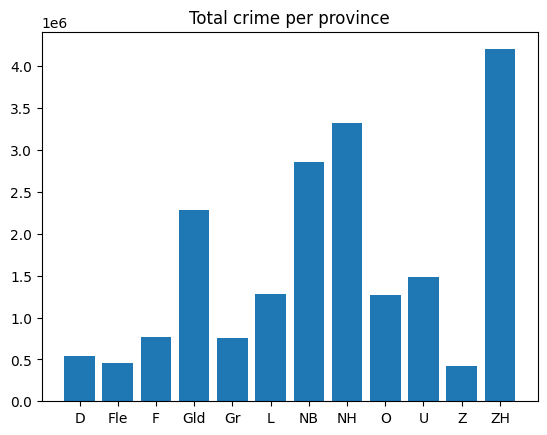

In [43]:
x = [short_province[tuples_total_crime[i][0]] for i in range(len(tuples_total_crime))]
height = [tuples_total_crime[i][1] for i in range(len(tuples_total_crime))]
plt.bar(x=x, height=height)
plt.title("Total crime per province")
plt.show()

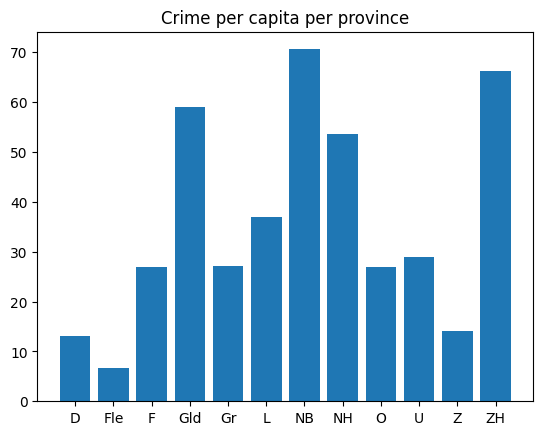

In [44]:
x = [short_province[tuples_crime_per_capita[i][0]] for i in range(len(tuples_crime_per_capita))]
height = [tuples_crime_per_capita[i][1] for i in range(len(tuples_crime_per_capita))]
plt.bar(x=x, height=height)
plt.title("Crime per capita per province")
plt.show()

                                     AantalInwoners  \
AantalInwoners                             1.000000   
TotaalVermogenVernielingEnGeweld          -0.996732   
TotaalVermogensmisdrijven                 -0.988437   
TotaalDiefstal                            -0.985249   
Fietsendiefstal                           -0.795305   
DiefstalOverigeVervoermiddelen            -0.730504   
DiefstalUitVanafVervoermiddelen           -0.717067   
ZakkenrollerijStraatroofEnBeroving        -0.745472   
TotaalDiefstalUitWoningSchuurED           -0.612326   
DiefstalUitNietResidentieleGebouwen       -0.782971   
OverigeDiefstalInbraak                    -0.781990   
OverigeVermogensmisdrijven                -0.701734   
TotaalVernielingTegenOpenbareOrde         -0.741464   
TotaalVernieling                          -0.682516   
VernielingAanAuto                         -0.690268   
OverigeVernieling                         -0.531982   
OverigeVernielingTegenOpenbareOrde        -0.762430   

         

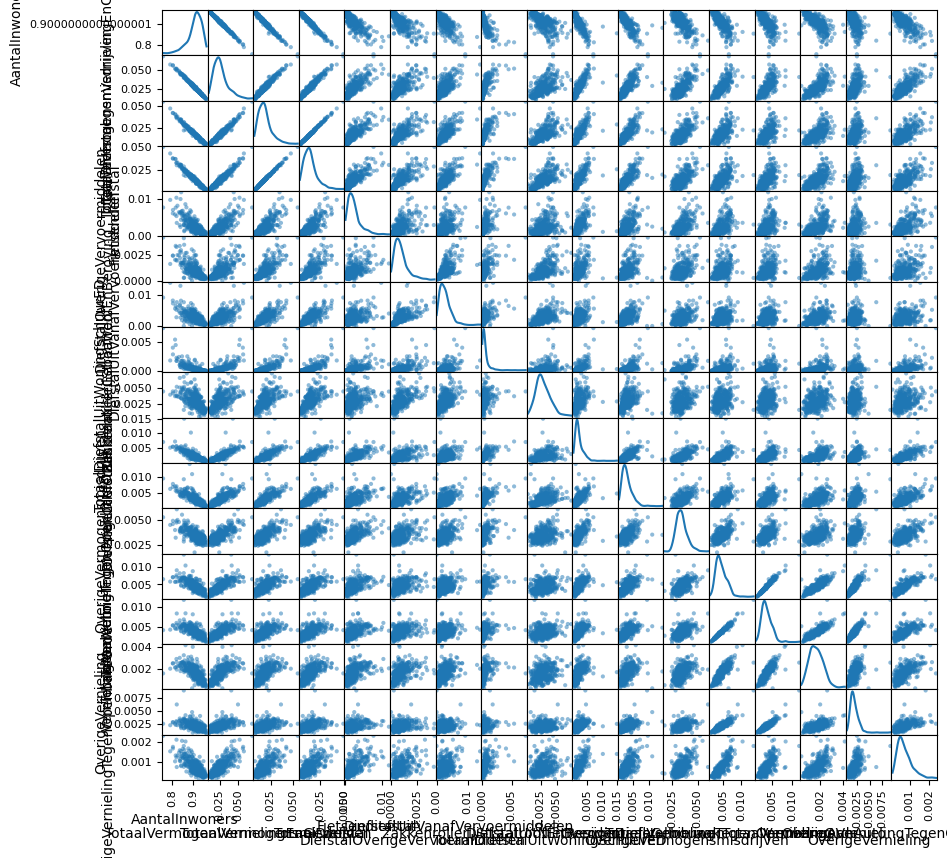

In [45]:
print(relative_crimes.corr())
pd.plotting.scatter_matrix(relative_crimes, figsize=(10, 10), diagonal='kde')
plt.show()

The plotting of this giant plot is not that sensible since some theft/crime numbers are made up of each other. Therefore, we will later investigate the main principle components (dimensionality reduction) and work with those.

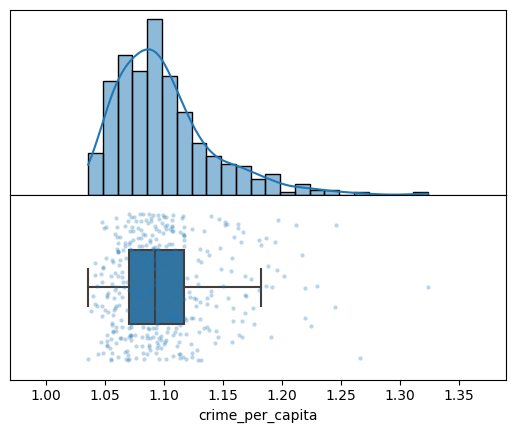

In [46]:
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    dfs_gemeente_and_features['crime_per_capita'],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    dfs_gemeente_and_features['crime_per_capita'], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    dfs_gemeente_and_features['crime_per_capita'],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(dfs_gemeente_and_features['crime_per_capita']) * 0.05
xmin = np.min(dfs_gemeente_and_features['crime_per_capita']) - spacer
xmax = np.max(dfs_gemeente_and_features['crime_per_capita']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

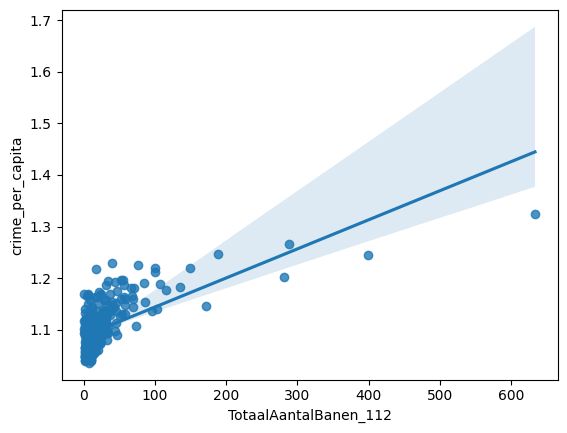

In [47]:
sns.regplot(x=dfs_gemeente_and_features['TotaalAantalBanen_112'], y=dfs_gemeente_and_features['crime_per_capita'])
plt.show()


C:\Users\Martijn Elands\AppData\Local\Temp\ipykernel_22516\3115759026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noCity['werkloos_per_capita'] = noCity['Werkloosheid_155'].div(noCity['AantalInwoners'])


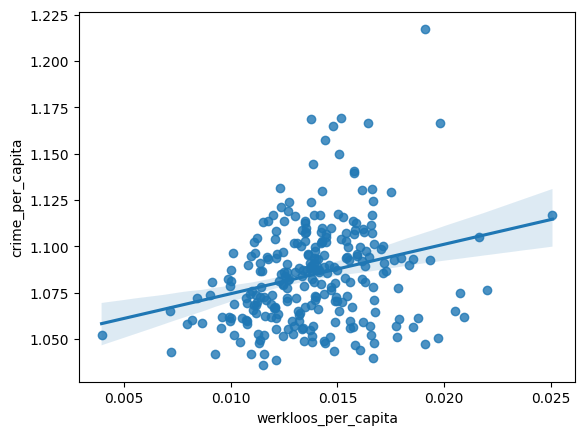

In [48]:
noCity = dfs_gemeente_and_features.loc[dfs_gemeente_and_features['AantalInwoners']<40000] 
noCity['werkloos_per_capita'] = noCity['Werkloosheid_155'].div(noCity['AantalInwoners'])
sns.regplot(x=noCity['werkloos_per_capita'], y=noCity['crime_per_capita'])

plt.show()

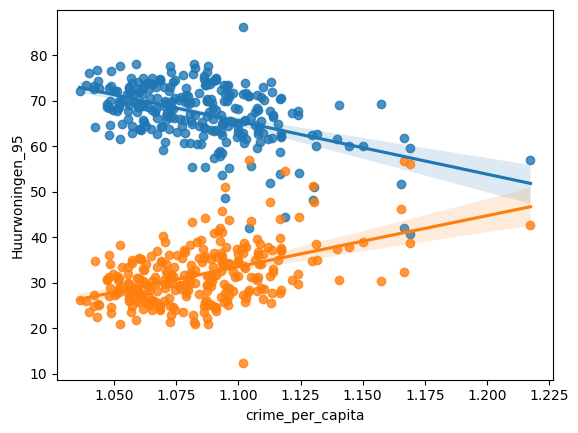

In [49]:
sns.regplot(x=noCity['crime_per_capita'], y=noCity['Koopwoningen_94'])
sns.regplot(x=noCity['crime_per_capita'], y=noCity['Huurwoningen_95'])

plt.show()

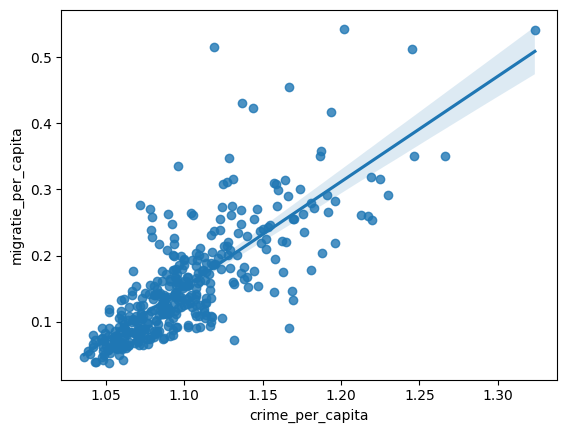

In [50]:
dfs_gemeente_and_features['migratie_per_capita'] = dfs_gemeente_and_features['TotaalMetMigratieachtergrond_35'].div(dfs_gemeente_and_features['AantalInwoners'])
sns.regplot(x=dfs_gemeente_and_features['crime_per_capita'], y=dfs_gemeente_and_features['migratie_per_capita'])

plt.show()

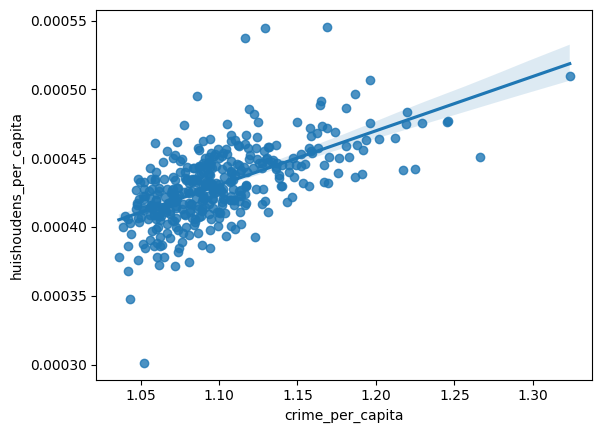

In [51]:
dfs_gemeente_and_features['huishoudens_per_capita'] = dfs_gemeente_and_features['ParticuliereHuishoudensExclStudenten_121'].div(dfs_gemeente_and_features['AantalInwoners'])

sns.regplot(x=dfs_gemeente_and_features['crime_per_capita'], y=dfs_gemeente_and_features['huishoudens_per_capita'])

plt.show()

In [52]:
dfs_gemeente_and_features['Mannen_2']


0       5757.666667
1       5238.000000
2       4534.000000
3       3611.500000
4      12481.000000
           ...     
386    23404.500000
387    12486.500000
388    30561.500000
389    17843.333333
390     6181.000000
Name: Mannen_2, Length: 391, dtype: float64

In [53]:
relative_gemeente_features = dfs_gemeente_and_features.iloc[:,21:]
relative_gemeente_features['Bevolkingsdichtheid_57'] = relative_gemeente_features['Bevolkingsdichtheid_57'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['TotaalAantalBanen_112'] = relative_gemeente_features['TotaalAantalBanen_112'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Werkloosheid_155'] = relative_gemeente_features['Werkloosheid_155'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Mannen_2'] = relative_gemeente_features['Mannen_2'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)
relative_gemeente_features['Vrouwen_3'] = relative_gemeente_features['Vrouwen_3'].div(dfs_gemeente_and_features.AantalInwoners, axis=0)

relative_gemeente_features.drop(columns=['TotaalMetMigratieachtergrond_35','ParticuliereHuishoudensExclStudenten_121'], inplace=True)

relative_gemeente_features

,ID,Mannen_2,Vrouwen_3,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,Werkloosheid_155,Province,total_crime,crime_per_capita,migratie_per_capita,huishoudens_per_capita
0,2515.0,0.482850,0.509323,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,29.033333,0.016493,Groningen,13050.666667,1.094457,0.139323,0.000464
1,2906.5,0.500653,0.500749,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,30.150000,0.016727,Groningen,10962.666667,1.047822,0.075509,0.000416
2,3130.0,0.506875,0.490218,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,29.600000,0.016769,Groningen,9522.000000,1.064505,0.108776,0.000447
3,4054.5,0.494004,0.503169,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,30.900000,0.014363,Groningen,7666.666667,1.048696,0.070513,0.000404
4,5203.0,0.499927,0.495360,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,30.066667,0.016556,Groningen,27757.000000,1.111807,0.177818,0.000459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,19679.5,0.507558,0.491531,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,29.800000,0.014421,Friesland,48839.000000,1.059139,0.086322,0.000434
387,20407.5,0.505854,0.504578,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,30.300000,0.013774,Groningen,27747.000000,1.124088,0.105088,0.000450
388,12903.5,0.501411,0.498179,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,30.000000,0.015914,Groningen,65526.000000,1.075060,0.142943,0.000448
389,13211.0,0.504448,0.503590,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,31.266667,0.014512,Gelderland,38397.666667,1.085538,0.122253,0.000433


In [54]:
cats = [
    'Friesland',
    'Groningen',
    'Drenthe',
    'Overijsel',
    'Noord-Holland',
    'Zuid-Holland',
    'Brabant',
    'Limburg',
    'Utrecht',
    'Zeeland',
    'Flevoland',
    'Gelderland'
]
cats = list(short_province.keys()) #try enabling this
cat_type = CategoricalDtype(categories=cats)
relative_gemeente_features['Province'] = relative_gemeente_features['Province'].astype(cat_type)
relative_gemeente_features = pd.get_dummies(relative_gemeente_features,
                          prefix='pro',
                          columns=['Province'], 
                          drop_first=True)


In [55]:
relative_gemeente_features

,ID,Mannen_2,Vrouwen_3,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,...,pro_Overijssel,pro_Flevoland,pro_Gelderland,pro_Utrecht,pro_Noord-Holland,pro_Zuid-Holland,pro_Zeeland,pro_Noord-Brabant,pro_Limburg,pro_Groningen
0,2515.0,0.482850,0.509323,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,29.033333,...,0,0,0,0,0,0,0,0,0,1
1,2906.5,0.500653,0.500749,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,30.150000,...,0,0,0,0,0,0,0,0,0,1
2,3130.0,0.506875,0.490218,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,29.600000,...,0,0,0,0,0,0,0,0,0,1
3,4054.5,0.494004,0.503169,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,30.900000,...,0,0,0,0,0,0,0,0,0,1
4,5203.0,0.499927,0.495360,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,30.066667,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,19679.5,0.507558,0.491531,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,29.800000,...,0,0,0,0,0,0,0,0,0,0
387,20407.5,0.505854,0.504578,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,30.300000,...,0,0,0,0,0,0,0,0,0,1
388,12903.5,0.501411,0.498179,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,30.000000,...,0,0,0,0,0,0,0,0,0,1
389,13211.0,0.504448,0.503590,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,31.266667,...,0,0,1,0,0,0,0,0,0,0


In [56]:
#c1 = Counter(relative_gemeente_features['Province'])

#x = list(c1.keys())
#x_prime = [short_province[k] for k in x]
#height = list(c1.values())
#plt.bar(x=x_prime, height=height)
#plt.title("Number of data entries for each province")
#plt.show()

## Dimensionality Reduction using PCA/SVD

In [57]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

def dataframe_PCA(data: pd.DataFrame, columns_to_drop: list, limit_components: int = -1) -> pd.DataFrame:
    """
    Generates PCA dataframe by the data. It also offers some cleaning and it has automatic scaling.

    Args:
        data (pd.DataFrame): data that needs to be cleaned (with column removal) and scaled
        columns_to_drop (list): columns to drop for cleaning
        limit_components (int, optional): limits the amount of components for PCA. Defaults to -1 which is no limit.

    Returns:
        pd.DataFrame: PCA dataframe
    """
    cleaned_data = data.drop(columns=columns_to_drop) # Some cleaning before PCA
    print(cleaned_data.columns)
    X = scale(cleaned_data.values) # Scale dataset

    # Create PCA and transform to new coordinate system
    if (limit_components == -1):
        PCA_model = PCA()
    else:
        PCA_model = PCA(limit_components)
    X_PCA = PCA_model.fit_transform(X)

    # Create new DataFrame to check the
    #print(len(cleaned_data.columns))
    columns = ["PC_" + str(i) for i in range(len(cleaned_data.columns))]
    df_PCA = pd.DataFrame(X_PCA, columns=columns)

    #print(PCA_model.explained_variance_)
    #print()
    #print(PCA_model.explained_variance_ratio_)
    print(PCA_model.singular_values_)
    print(PCA_model.get_feature_names_out())

    return df_PCA

df_PCA = dataframe_PCA(data=relative_gemeente_features, columns_to_drop=['ID'])

Index(['Mannen_2', 'Vrouwen_3', 'Bevolkingsdichtheid_57', 'Koopwoningen_94',
       'Huurwoningen_95', 'EigendomOnbekend_96', 'TotaalAantalBanen_112',
       'TypePaarZonderKind_135', 'BronInkomenAlsWerknemer_137',
       'Werkloosheid_155', 'total_crime', 'crime_per_capita',
       'migratie_per_capita', 'huishoudens_per_capita', 'pro_Drenthe',
       'pro_Overijssel', 'pro_Flevoland', 'pro_Gelderland', 'pro_Utrecht',
       'pro_Noord-Holland', 'pro_Zuid-Holland', 'pro_Zeeland',
       'pro_Noord-Brabant', 'pro_Limburg', 'pro_Groningen'],
      dtype='object')
[44.50814837 34.99466951 25.11337434 23.76152606 23.05903702 21.65301825
 21.22489747 20.98029    20.86659109 20.39981524 20.2780504  19.55014106
 17.71790159 17.42301843 17.14543704 15.25646373 12.87460496 12.70497098
 11.09038517  9.21206332  8.636392    7.10538852  4.405695    3.76324628
  0.05198471]
['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca12' 'pca13' 'pca14' 'pca15' 'pca1

In [58]:
df_PCA

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24
0,1.878612,-2.143139,-3.137724,0.719116,-0.638509,-2.272971,-0.036186,0.690425,0.038722,-2.181370,...,0.859304,0.983156,-1.157350,0.454764,0.256550,0.484034,0.267529,-0.219213,0.113967,-0.002811
1,-1.761272,-1.811055,-1.882019,0.034824,-0.676295,-1.978691,0.101919,0.904915,-0.044143,-1.823720,...,1.279644,0.628011,0.271702,-0.083292,-0.324587,0.347947,0.284360,0.066907,-0.101838,-0.004851
2,-1.851290,-2.727043,-2.133068,-0.653132,-0.415066,-1.310143,0.304986,1.109977,-0.092377,-1.828956,...,0.312765,0.396763,0.456423,0.344085,0.047194,-0.725080,0.295908,-0.021053,-0.006206,0.000163
3,-2.969215,-0.838225,-2.132126,0.020922,-0.838170,-1.978719,-0.272747,0.787385,-0.006353,-1.908255,...,1.058132,1.071245,0.113499,-0.550205,-0.213951,-0.276844,-0.160621,0.495270,-0.017912,-0.001226
4,0.527385,-2.668060,-1.551293,-0.360837,-0.450783,-1.583772,0.064394,0.906584,0.024207,-1.948897,...,1.317224,0.273380,-0.114410,0.744454,0.082956,-0.820503,0.224902,-0.034868,0.224544,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,-1.552960,-1.665773,-0.070851,0.181788,-0.400971,-0.021131,-0.100816,0.100367,-0.121955,-0.063134,...,-0.759064,-0.577700,-0.124078,0.083430,0.396966,0.253315,0.348641,0.322152,0.686560,0.003780
387,-0.694559,-2.253472,-1.813653,-0.978094,1.870476,-0.197799,0.980847,1.568410,0.127992,-1.646683,...,0.743536,1.037792,-0.309893,-0.431082,0.053983,-1.080742,-0.498124,-0.153539,0.207062,0.009528
388,-0.205770,-2.490920,-1.635933,-0.176886,-0.299459,-1.636911,0.147737,1.095129,-0.012591,-1.936065,...,0.739787,0.613220,-0.329909,0.399391,-0.059927,-0.157239,0.521799,-0.057718,0.067350,-0.000138
389,-0.484294,-0.960007,0.397189,1.004765,0.862074,-0.651770,0.842090,-1.745226,-0.613232,-0.023174,...,0.097256,-0.347924,0.063180,0.097362,0.173236,-0.326161,0.198484,-0.231416,0.069491,-0.000232


## Regression time

In [59]:
## Cross-validation

"""from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
lm = LinearRegression()
scores = cross_val_score(lm, X, y, scoring='r2', cv=folds)
"""

"from sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import KFold, cross_val_score\n\nfolds = KFold(n_splits = 5, shuffle = True, random_state = 100)\nlm = LinearRegression()\nscores = cross_val_score(lm, X, y, scoring='r2', cv=folds)\n"

In [60]:
relative_gemeente_features

,ID,Mannen_2,Vrouwen_3,Bevolkingsdichtheid_57,Koopwoningen_94,Huurwoningen_95,EigendomOnbekend_96,TotaalAantalBanen_112,TypePaarZonderKind_135,BronInkomenAlsWerknemer_137,...,pro_Overijssel,pro_Flevoland,pro_Gelderland,pro_Utrecht,pro_Noord-Holland,pro_Zuid-Holland,pro_Zeeland,pro_Noord-Brabant,pro_Limburg,pro_Groningen
0,2515.0,0.482850,0.509323,0.041707,48.733333,51.133333,0.166667,0.000316,28.900000,29.033333,...,0,0,0,0,0,0,0,0,0,1
1,2906.5,0.500653,0.500749,0.022462,68.450000,31.200000,0.400000,0.000306,31.150000,30.150000,...,0,0,0,0,0,0,0,0,0,1
2,3130.0,0.506875,0.490218,0.009167,70.600000,28.400000,1.000000,0.000190,29.000000,29.600000,...,0,0,0,0,0,0,0,0,0,1
3,4054.5,0.494004,0.503169,0.022023,76.600000,23.300000,0.100000,0.000157,32.300000,30.900000,...,0,0,0,0,0,0,0,0,0,1
4,5203.0,0.499927,0.495360,0.007490,61.600000,37.933333,0.466667,0.000423,29.500000,30.066667,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,19679.5,0.507558,0.491531,0.003502,67.450000,32.100000,0.400000,0.000292,30.000000,29.800000,...,0,0,0,0,0,0,0,0,0,0
387,20407.5,0.505854,0.504578,0.003666,66.800000,29.700000,3.400000,0.000304,29.200000,30.300000,...,0,0,0,0,0,0,0,0,0,1
388,12903.5,0.501411,0.498179,0.003568,61.900000,37.500000,0.600000,0.000316,30.150000,30.000000,...,0,0,0,0,0,0,0,0,0,1
389,13211.0,0.504448,0.503590,0.009537,65.366667,34.500000,0.133333,0.000460,31.166667,31.266667,...,0,0,1,0,0,0,0,0,0,0


Busy with fold 0


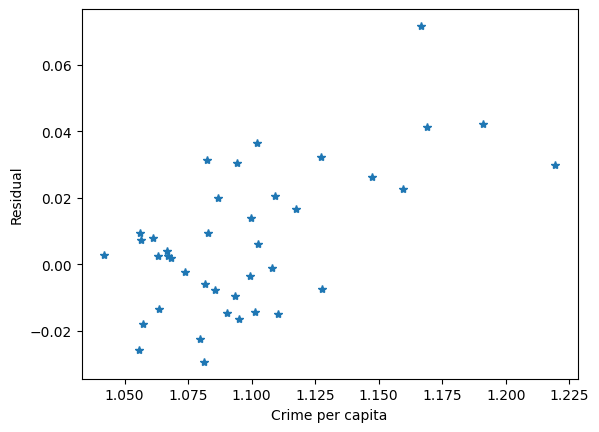

Busy with fold 1


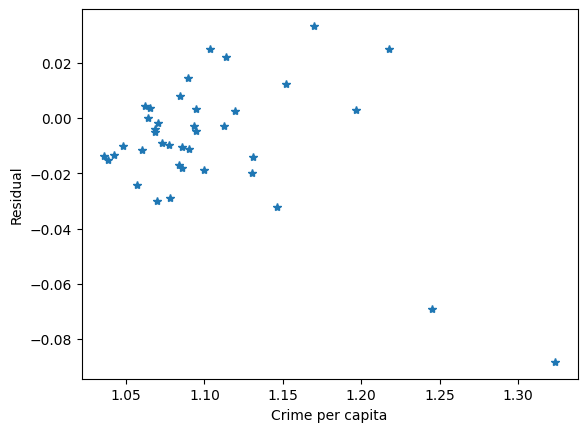

Busy with fold 2


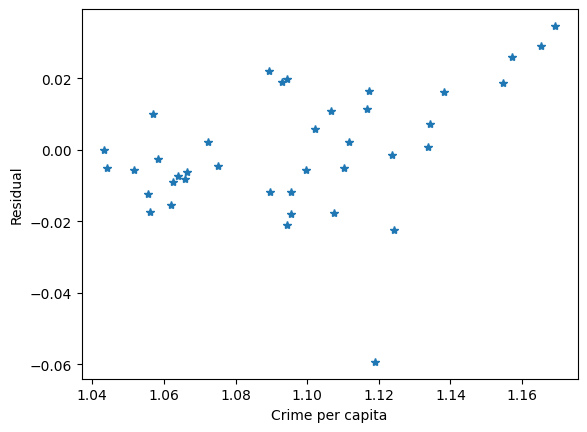

Busy with fold 3


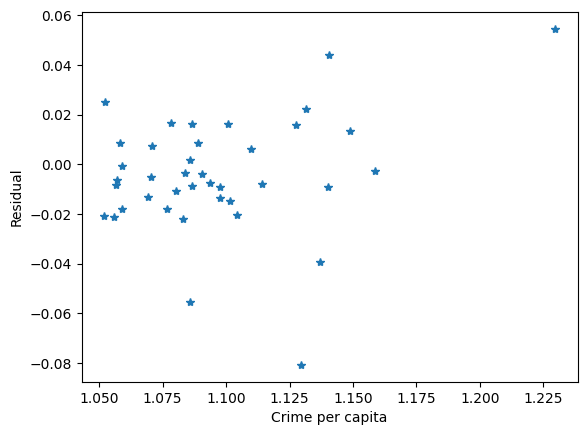

Busy with fold 4


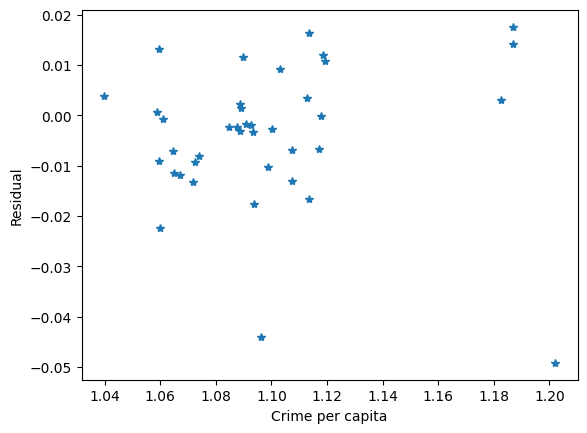

Busy with fold 5


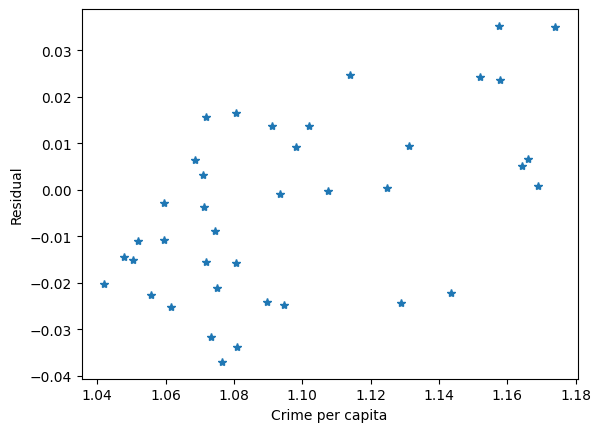

Busy with fold 6


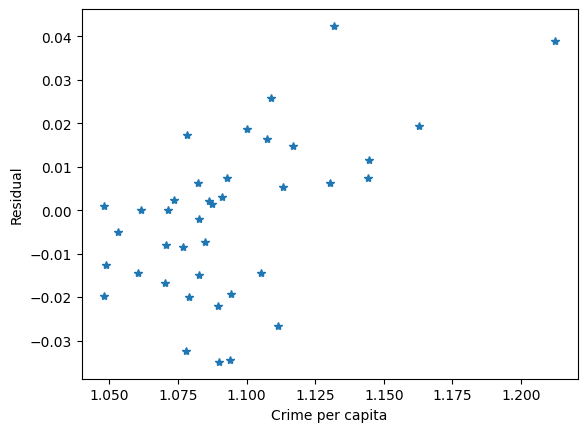

Busy with fold 7


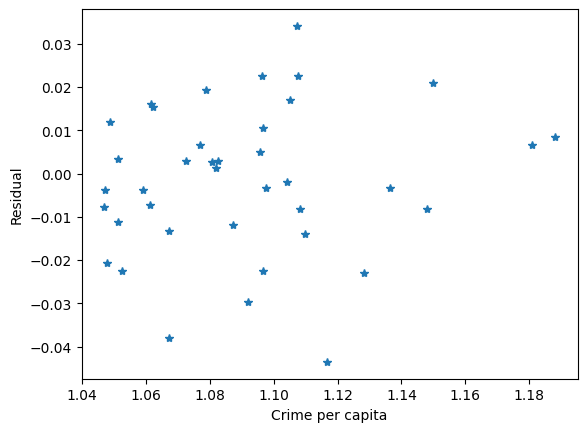

Busy with fold 8


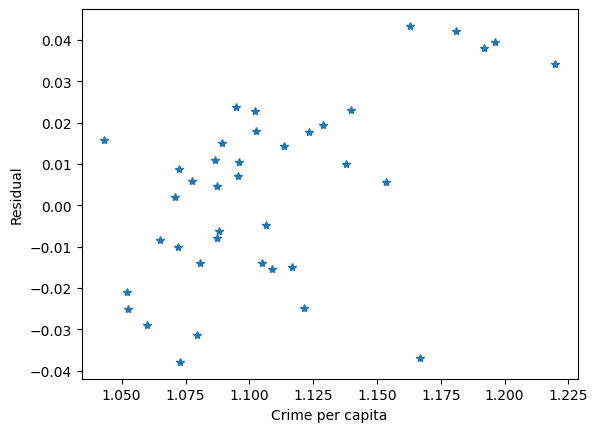

Busy with fold 9


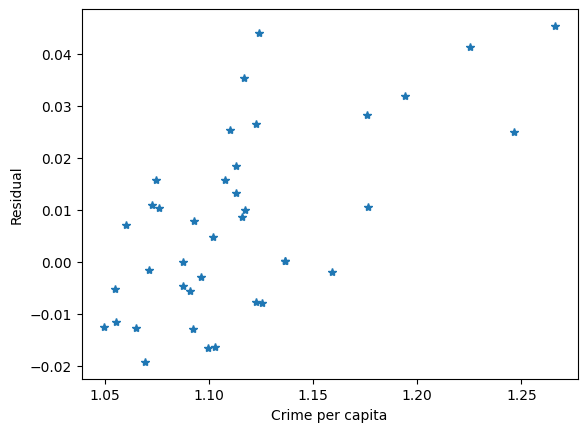

{'train': [0.00027513764662576634, 0.0002881813126053923, 0.0002952784128961983, 0.0002850578561179906, 0.00030552676521329174, 0.0002887087150191534, 0.00029152658900170533, 0.0002963423304104944, 0.00027657799391830103, 0.0002902948892856819], 'test': [0.0005080008047065526, 0.0005686099408735725, 0.0003012571277562313, 0.0005708752076346499, 0.00020714956234275668, 0.00037112290419522774, 0.0003327841808648028, 0.0002916097213129846, 0.0004923091388483606, 0.00036220933901599345]}
0.00028926325110939754
0.00040059279275511314


In [74]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metris import mean_absolute_error


k_folds = KFold(n_splits=10, shuffle=True, random_state=21)
X = relative_gemeente_features.drop(columns=['crime_per_capita'])
Y = relative_gemeente_features['crime_per_capita']

errors = {'train': [], 'test': []}
models = []

#i is folder number
#x_index is a list with x indices (so train or test indices)
for i, (train_index, test_index) in enumerate(k_folds.split(X)):
    print('Busy with fold', i)

    # Get train data
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]

    # Get test data
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

    model = LinearRegression()

    model.fit(X=X_train, y=y_train)
    y_pred_train = model.predict(X=X_train)
    mse_train = MSE(y_true=y_train, y_pred=y_pred_train)
    errors['train'].append(mse_train)

    y_pred_test = model.predict(X=X_test)
    mse_test = MSE(y_true=y_test, y_pred=y_pred_test)
    errors['test'].append(mse_test)

    models.append(model)

    # Need: residuals
    gm2_residuals = y_test - y_pred_test
    plt.plot(y_test, gm2_residuals, '*')
    plt.xlabel("Crime per capita")
    plt.ylabel("Residual")
    plt.show()
    #ax = sns.regplot(x=y_test, y=gm2_residuals)
    #ax.set_xlabel('Sale Price (Test Data)')
    #ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
    #plt.plot(ax)

print(errors)
print(np.average(errors['train']))
print(np.average(errors['test']))

In [ ]:
## Stratified cross-validation

In [ ]:
## Cross-validation with SEPERATE test set outside

## Ethics